### focus stacking w.r.t. distance from focus

In [1]:
import numpy as np
import subprocess
import glob
import skimage.io as imio
import re
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
## camera behavior
def initialFocus(sid=0):
    #10.42.0.90: local 10.236.176.75: ip
    cmD='ssh nvidia@10.236.176.75 "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -init "'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def moveFocus(sid=0, pos=512):
    cmD='ssh nvidia@10.236.176.75 "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -mod '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def setFocus(sid=0, pos=512):
    cmD='ssh nvidia@10.236.176.75 "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -set '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

def grab_image(sid=0, imres=8):
# I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images

    subprocess.run('ssh nvidia@10.236.176.75 "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)

    # ok, now let's grab an image on the tegra
    subprocess.run('ssh nvidia@10.236.176.75 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name dbGrab --image-res '+str(imres)+'"', stdout=subprocess.PIPE, shell=True)
    subprocess.run('scp nvidia@10.236.176.75:dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
#     pop=skimage.transform.rotate(pop,180)
    subprocess.run('mv dbGrab* photo_arch/', \
                   stdout=subprocess.PIPE, shell=True)
    
    return pop

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))
from tensorflow.python.keras.models import load_model
dist_est_net = load_model('050-0.65.hdf5')
from quad_solver import solver
#     curr0 = curr + solver(curr, step)[0]
#     curr1 = curr + solver(curr, step)[1]

Using TensorFlow backend.
W1128 21:35:19.029131 140656760805120 deprecation.py:506] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1128 21:35:19.030076 140656760805120 deprecation.py:506] From /home/qian/anaconda3/envs/pytorch/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
## blockwise estimate focus status
def reflect_pad(img, left, up):
    return np.pad(img, ((up, up), (left, left)), 'reflect')

def stack_blocks(img, window_size, step):
    H, W = img.shape
    stack = []
    for i in range(0, H, step):
        for j in range(0, W, step):
            patch = img[i:i+window_size, j:j+window_size]
            #patch = (patch-np.min(patch))/(np.max(patch)-np.min(patch))
            stack.append(patch)
    stack = np.stack(stack)[..., np.newaxis]
    return stack
    
def dist_est(gray_img, curr, last_dist_map = None, last_move_steps = None):
    # dist_list contain blockwise dist it stores. 0 indicates the block has been in-focused before.
    # last_move_steps 
    H, W = gray_img.shape
    window_size = 512
    step = 512
    if H % window_size != 0:
        up = (window_size - (H % window_size))//2
    if W % window_size != 0:
        left = (window_size - (W % window_size))//2
    gray_img = reflect_pad(gray_img, left, up)    
    H, W = gray_img.shape
    
    plt.imshow(gray_img)
    plt.grid(color='w', linestyle='-', linewidth=2)
    plt.xticks(np.arange(0, W, window_size))
    plt.yticks(np.arange(0, H, window_size))
    plt.show()

    if last_dist_map is None:
        last_dist_map = np.ones((H//step, W//step))
    
    dist_map = np.zeros(last_dist_map.shape)
      

    gray_img_stack = stack_blocks(gray_img, window_size, step)
    stime = time.time()
    
    dst_stack = dist_est_net.predict(gray_img_stack)
    #print("network runtime elapsed: {}".format(time.time()-stime))
    dst_stack = dst_stack.reshape(H//step, W//step)
#     for i in range(H//step):
#         for j in range(W//step):
#             if last_dist_map[i, j] != 0:
#                 dst = dst_stack[i, j]
#                 if dst < 2:
#                     dst=0
#                 dist_map[i, j] = dst
    dist_map = dst_stack

    stime = time.time()
    
    if last_move_steps is not None:
        ## Focus direction: simple check
        mapa = dist_map - last_move_steps
        mapb = -dist_map - last_move_steps
        diffa = np.abs(mapa) - last_dist_map
        diffb = np.abs(mapb) - last_dist_map
        mask = (np.abs(diffa) < np.abs(diffb)).astype(np.float64)
        dist_map = (dist_map * mask + (1-mask) * (-dist_map))

    ## grouping and pick one distance to move
    dist_vec = dist_map.flatten()
    
    dd_map = np.zeros(dist_vec.shape)
    for i, dis in enumerate(dist_vec):
        dd_map[i] = curr + solver(curr, -dis)
    dd_map = dd_map.reshape(dist_map.shape)
    
    
    #dist_vec = dist_vec[dist_vec!=0]
    dist_vec = dist_vec[np.abs(dist_vec)>1.5]
    n, bins, patches = plt.hist(dist_vec, bins=10)

    idx_sorted = np.argsort(n)[::-1]
    flag = False
    for i in range(len(n)):
        dist_to_move = -(bins[idx_sorted[i]]+bins[idx_sorted[i]+1])/2
        #print("trial {}: est curr: {}".format(i, curr + solver(curr, dist_to_move)))
        if (curr + solver(curr, dist_to_move) > 375) and (curr + solver(curr, dist_to_move) < 1100):
            flag = True
            break
    
    #print("grouping and findmax time elapsed: {}".format(time.time()-stime))
    
    plt.show()
    plt.imshow(dd_map)
#     plt.grid(color='w', linestyle='-', linewidth=2)
    plt.colorbar()
    for (j,i),label in np.ndenumerate(dd_map):
        plt.text(i,j,int(label), color='white',ha='center',va='center', fontsize=12)
    plt.show()
    
    return flag, np.abs(dist_map), dist_to_move


In [5]:
# initialFocus()
# import cv2
curr = 1000
# setFocus(pos = curr)

# img = grab_image()
# gray_img = rgb2gray(img)

# plt.imshow(img)
# plt.show()
# print(gray_img.max())

In [6]:
dist_map = None
dist_to_move = None
# while (dist_map is None) or (np.max(dist_map) > 1):

round:  0


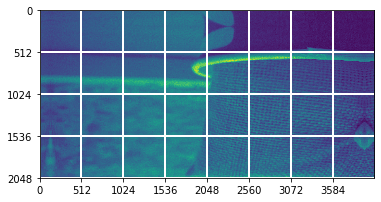

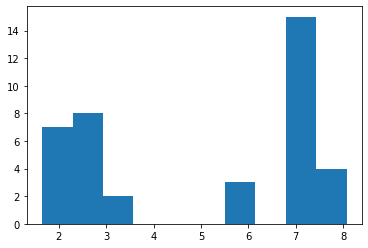

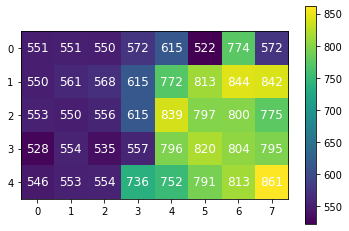

distance to move:  -7.107533931732178
round 1 -- current focus pos is: 560.1094929910616
round:  1


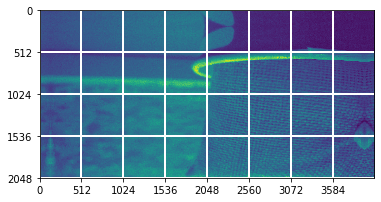

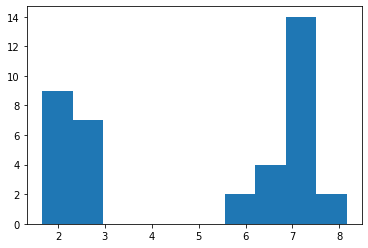

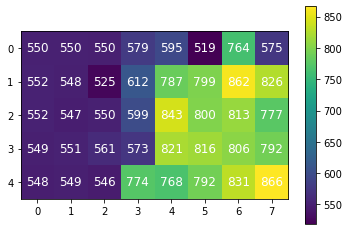

distance to move:  -7.181207656860352
round 2 -- current focus pos is: 557.136970979011
round:  2


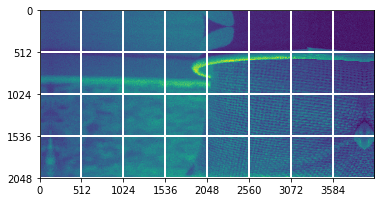

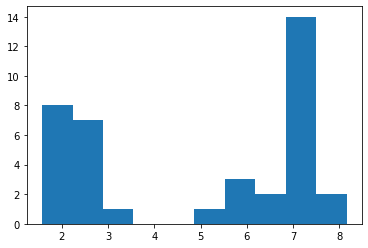

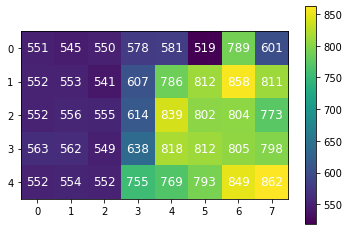

distance to move:  -7.16844367980957
round 3 -- current focus pos is: 557.6509673361502
round:  3


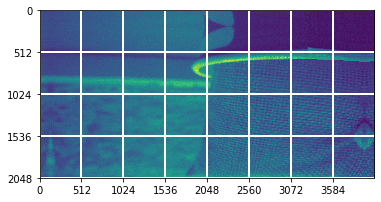

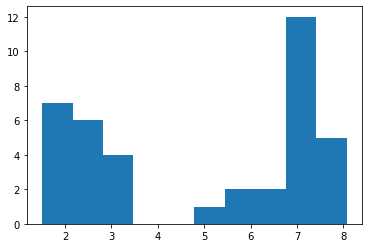

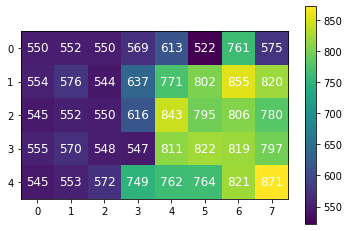

distance to move:  -7.083160400390625
round 4 -- current focus pos is: 561.0959642595164
round:  4


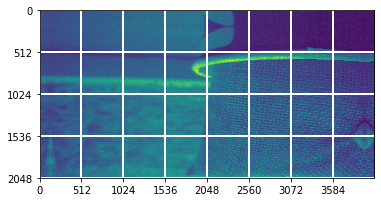

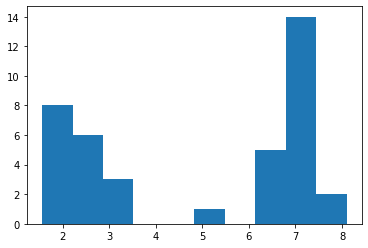

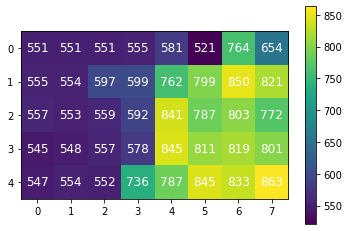

distance to move:  -7.116023063659668
round 5 -- current focus pos is: 559.7662717241512


In [7]:
imgs = []
for i in range(5):
    print("round: ", i)
    curr = 1000
    dist_map = None
    dist_to_move = None
    setFocus(pos = curr)
    img = grab_image()
    imgs.append(img)
    gray_img = rgb2gray(img)

    flag, dist_map, dist_to_move = dist_est(gray_img, curr, dist_map, dist_to_move)

    if flag is False:
        break
    print("distance to move: ", dist_to_move)
    curr = curr + solver(curr, dist_to_move)
    curr = np.clip(curr, 425, 1023)
    print("round {} -- current focus pos is: {}".format(i+1, curr))
imgs = np.stack(imgs)
#     print(dist_map)
